"covid_dataset.csv" contains data about COVID patients, offering a glimpse into COVID symptoms and diagnosis. In this notebook I created a predictive model. I would appreciate any feedback as it is my first data science project and I have recently started with programming and data science. 

In [2]:
import seaborn as sns
import sklearn.model_selection 
import sklearn.linear_model
import sklearn.metrics
import matplotlib.pyplot as plt
import pandas as pd

Once we have imported the libraries that we are going to uses we are going to load the dataset and visualize the data.

In [3]:
df = pd.read_csv("/home/carlos/pythoneo/datos/covid_dataset.csv")
df.head()

,Age,Gender,Fever,Cough,City,Has_Covid
0,56,Male,102.4,Mild,Mumbai,No
1,19,Female,101.6,Strong,Mumbai,No
2,76,Female,102.0,Mild,Kolkata,No
3,65,Male,99.7,Mild,Bangalore,No
4,25,Female,102.1,Mild,Delhi,Yes


We can see that the response variable is "Has_Covid", which is a binary outcome. There are also 5 predictors, 2 numerical variables ("Age" and "Fever") and 3 categorical variables ("Gender", "Cough" and "City"). 
Next we will take a look into the dataset in order to identify if there are any missing data


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        1000 non-null   int64  
 1   Gender     1000 non-null   object 
 2   Fever      1000 non-null   float64
 3   Cough      1000 non-null   object 
 4   City       1000 non-null   object 
 5   Has_Covid  1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


The .info() function informs us that there are no missing data and also show us that there is no need to transform the Age and Fever values into numerical values, as they are already integers and float, respectively.
In addition, the absence of missing data saves us using methods like dropping columns or imputation.

However, it is necessary to convert the categorical variables into binary creating dummy variables.

In [5]:
df = pd.get_dummies(df, columns = ["Cough", "Gender", "Has_Covid"], dtype = int)

First of all we are going to realize an EDA.

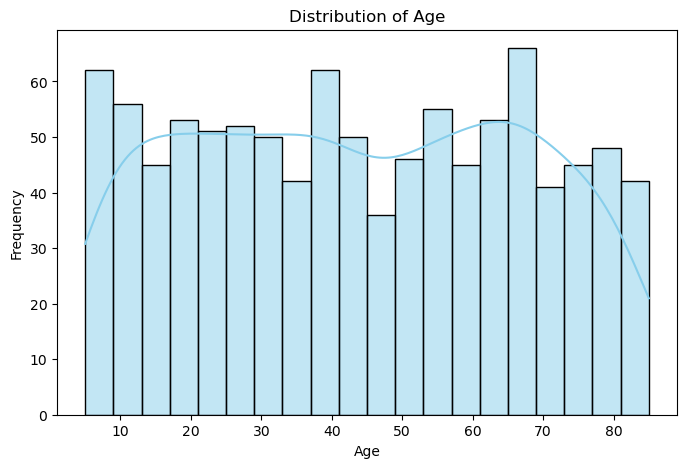

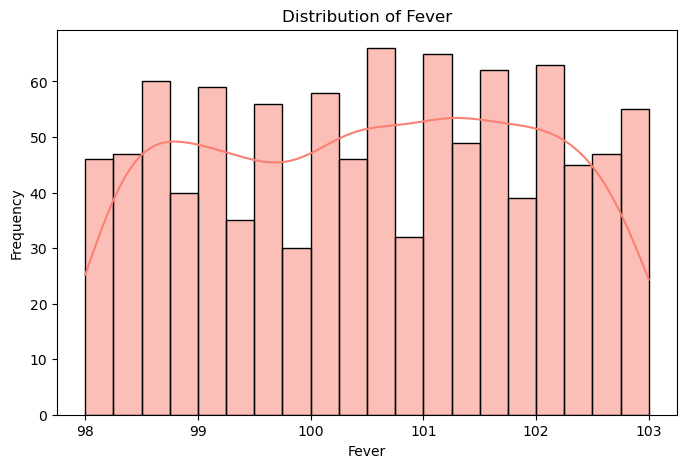

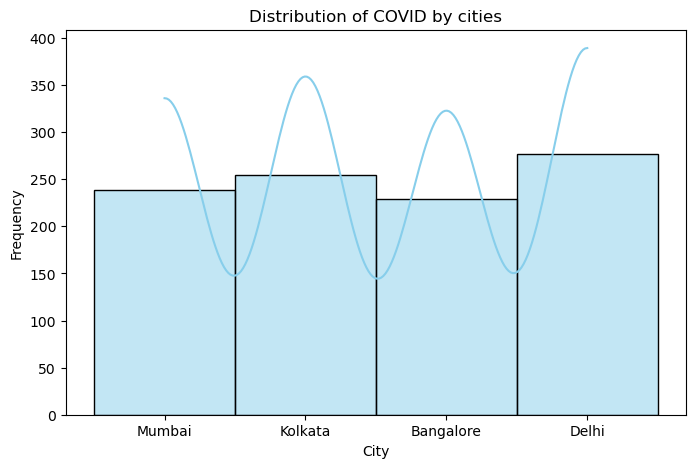

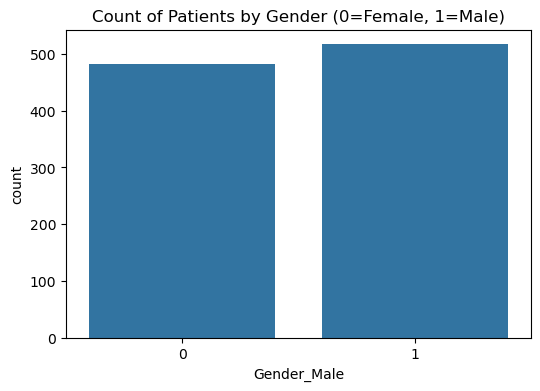

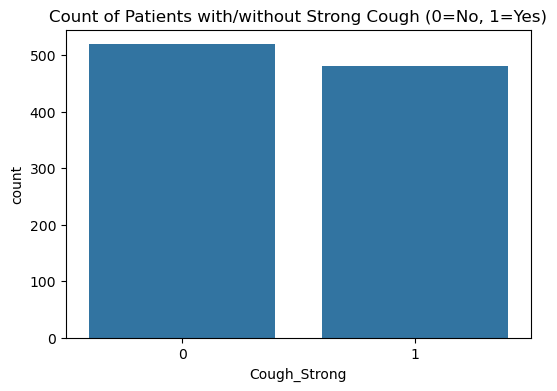

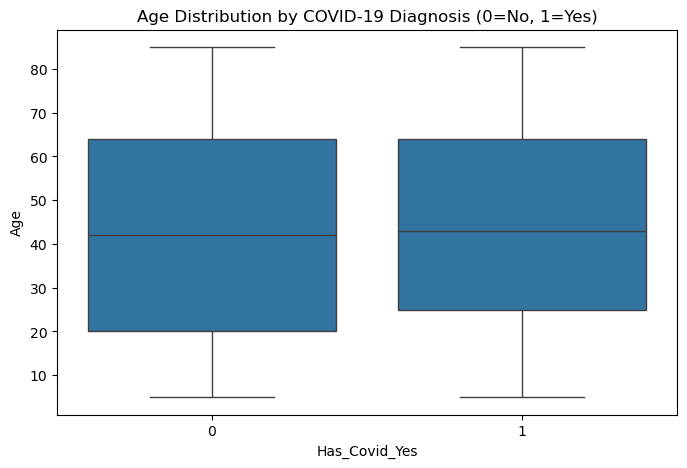

In [6]:
# Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Fever distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Fever'], bins=20, kde=True, color='salmon')
plt.title('Distribution of Fever')
plt.xlabel('Fever')
plt.ylabel('Frequency')
plt.show()

# City distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['City'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of COVID by cities')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.show()

# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender_Male', data=df)
plt.title('Count of Patients by Gender (0=Female, 1=Male)')
plt.show()

# Cough total count
plt.figure(figsize=(6, 4))
sns.countplot(x='Cough_Strong', data=df)
plt.title('Count of Patients with/without Strong Cough (0=No, 1=Yes)')
plt.show()

# Age and COVID
plt.figure(figsize=(8, 5))
sns.boxplot(x='Has_Covid_Yes', y='Age', data=df)
plt.title('Age Distribution by COVID-19 Diagnosis (0=No, 1=Yes)')
plt.show()

Once the exploratory data analysis is done we proceed with the predictive model

Test Set Accuracy: 0.535


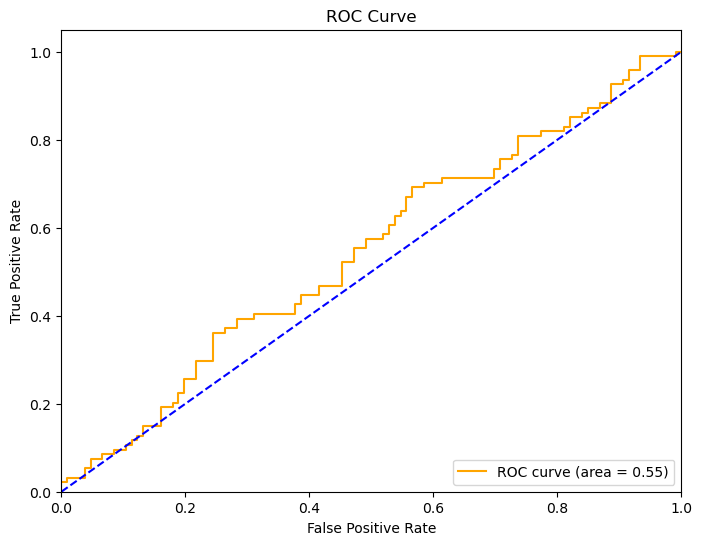

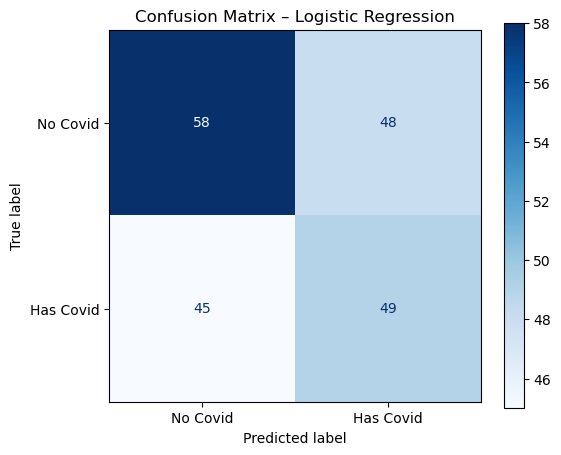

In [7]:
# Predictor and outcome selection 
X = df[["Fever","Cough_Strong","Age","Gender_Male","City"]]
y = df["Has_Covid_Yes"]

# Training and test datasets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size = 0.8, random_state = 42)

# Once the dataset is divided a city average is computed using training data
city_target_mean = X_train.join(y_train).groupby('City')['Has_Covid_Yes'].mean()

# Sustitution of the original city names for their numeric codes
X_train['City_encoded'] = X_train['City'].map(city_target_mean)
X_test['City_encoded'] = X_test['City'].map(city_target_mean)
X_train = X_train.drop(columns=['City'])
X_test = X_test.drop(columns=['City'])

# Logistic model
model = sklearn.linear_model.LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train,y_train)

# Test set predictions and model accuracy
y_pred = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.3f}")

#ROC curve plotting
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_probs)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Confusion matrix plotting
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=["No Covid", "Has Covid"])
plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


The created model presents a ROC-AUC score slightly above 0.5, which shows that the model has a very low predictive power. However, the biggest issue of this model is not its accuracy nor its low predictive power, its the high rate of false negatives, which is a serious issue in healthcare. This dataset does not contain enough signal for reliable COVID diagnosis using a linear model and these features, probably the use of a non-linear model or a linear model considering interactions between variables could result in better results.